In [145]:
import torch
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch.optim as optim
from tqdm import tqdm

In [146]:
def get_path(txt_path, dataset='train'):
    train_img_pth = []
    train_label_pth = []

    with open(txt_path, 'r') as f:
        for line in f:
            pth = Path(line.strip())
            train_img_pth.append(pth)
            name = pth.name.split('.')[0]

            pth = Path(f'/Users/kuba/Documents/data/Raw/Face-Detection-Dataset/labels/{dataset}/{name}.txt')
            train_label_pth.append(pth)

    return train_img_pth, train_label_pth



In [147]:
X_pth, y_pth = get_path("/Users/kuba/projects/swvl/train_16_single.txt", dataset='train')
len(X_pth), len(y_pth)

(16, 16)

Great we now have the paths to them all but how can we add them into one big tensor? They have different dims so this won't be trivial?

We will resize them to all be the same size!

In [148]:
def process_and_pad_data(img_paths, label_paths, target_size=(224, 224)):
    images = []
    bboxes = []
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(target_size, antialias=True),  # Resize all images to same dimensions
    ])

    for f_img, f_label in zip(img_paths, label_paths):
        image = Image.open(f_img)
        img_tensor = transform(image)
        
        with open(f_label, 'r') as f:
            label = f.readline().strip()
            bbox = torch.tensor([float(x) for x in label.split()])
        
        images.append(img_tensor)
        bboxes.append(bbox)
    
    X = torch.stack(images)  
    y = torch.stack(bboxes)
    
    return X, y

X, y = process_and_pad_data(X_pth, y_pth)
print("Train images shape:", X.shape)
print("Train bboxes shape:", y.shape)

Train images shape: torch.Size([16, 3, 224, 224])
Train bboxes shape: torch.Size([16, 5])


Now lets take a look at our train set

In [149]:
def calculate_center_coordinates(im, bbox_pred):
    center_x_pxl = int(len(im[0]) * bbox_pred[1]) #img width * percent x
    center_y_pxl = int(len(im) * bbox_pred[2]) #img height * percent y
    return center_x_pxl, center_y_pxl

def calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox_pred):
    half_width = int(len(im[0]) * (bbox_pred[3] / 2))
    half_height = int(len(im) * (bbox_pred[4] / 2))
    
    return {
        'y0': center_y_pxl + half_height,
        'y1': center_y_pxl - half_height,
        'x0': center_x_pxl + half_width,
        'x1': center_x_pxl - half_width,
        'xmin': center_x_pxl - half_width,
        'xmax': center_x_pxl + half_width,
        'ymin': center_y_pxl - half_height,
        'ymax': center_y_pxl + half_height
    }


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0032678808..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03907385..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.021943567..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0016887592..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


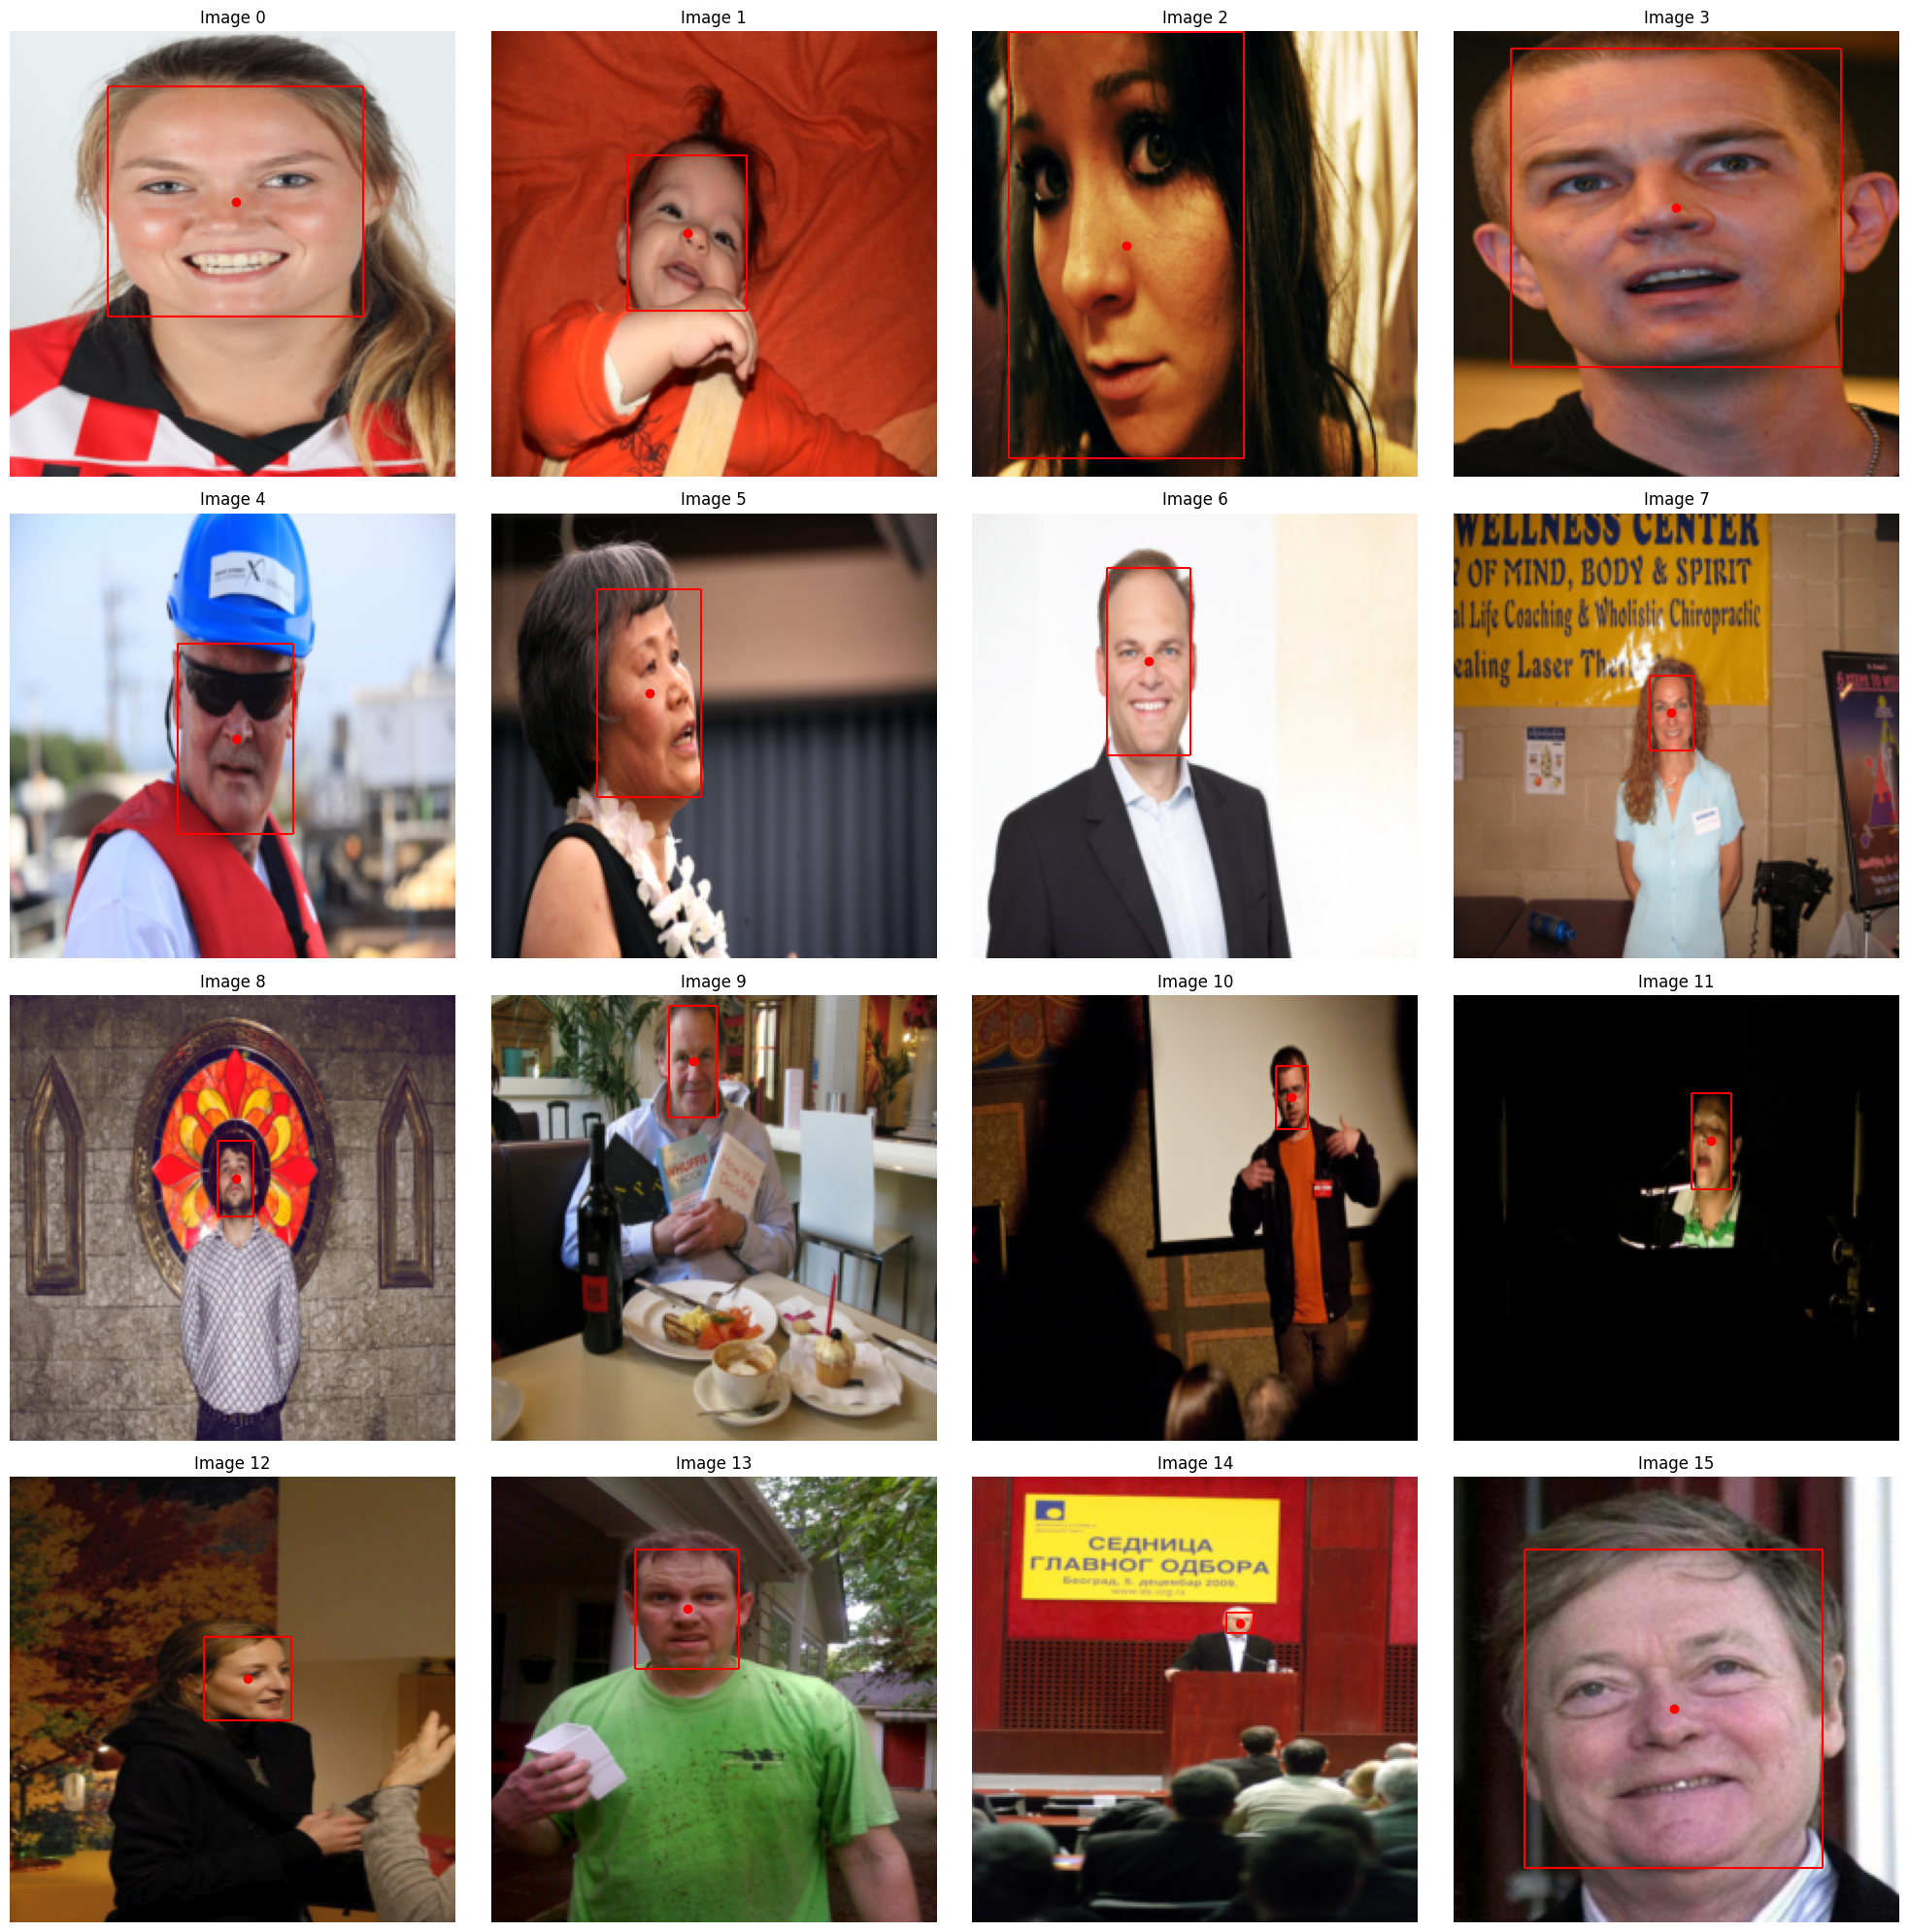

In [150]:
def plot_image_grid(images, bboxes, epoch, images_per_row=4):
    num_images = len(images)
    num_rows = (num_images + images_per_row - 1) // images_per_row  
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, 5*num_rows))
    
    if num_rows > 1:
        axes = axes.flatten()
    elif num_rows == 1:
        axes = [axes] if num_images == 1 else axes
    
    for idx, (img_tensor, bbox) in enumerate(zip(images, bboxes)):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        im = img_tensor.permute(1, 2, 0).numpy()
        
        center_x_pxl, center_y_pxl = calculate_center_coordinates(im, bbox)
        coords = calculate_box_dimensions(im, center_x_pxl, center_y_pxl, bbox)
        
        ax.imshow(im)
        ax.plot(center_x_pxl, center_y_pxl, 'ro')
        
        # horizontal lines
        ax.hlines(coords['y0'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
        ax.hlines(coords['y1'], xmin=coords['xmin'], xmax=coords['xmax'], colors='red')
        
        # vertical lines
        ax.vlines(coords['x0'], coords['ymin'], coords['ymax'], colors='red')
        ax.vlines(coords['x1'], coords['ymin'], coords['ymax'], colors='red')
        
        ax.set_title(f'Image {idx}')
        ax.axis('off')
    
    for idx in range(len(images), len(axes)):
        axes[idx].axis('off')
    
    # plt.suptitle(f'Epoch {epoch}', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_image_grid(X, y, epoch=0)

Now lets take a look at the val images

In [151]:
X_pth_dev, y_pth_dev = get_path("/Users/kuba/projects/swvl/test_5_single.txt", dataset='val')
print(len(X_pth_dev))
print(len(y_pth_dev))



5
5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.002038296..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


Dev images shape: torch.Size([16, 3, 224, 224])
Dev bboxes shape: torch.Size([16, 5])


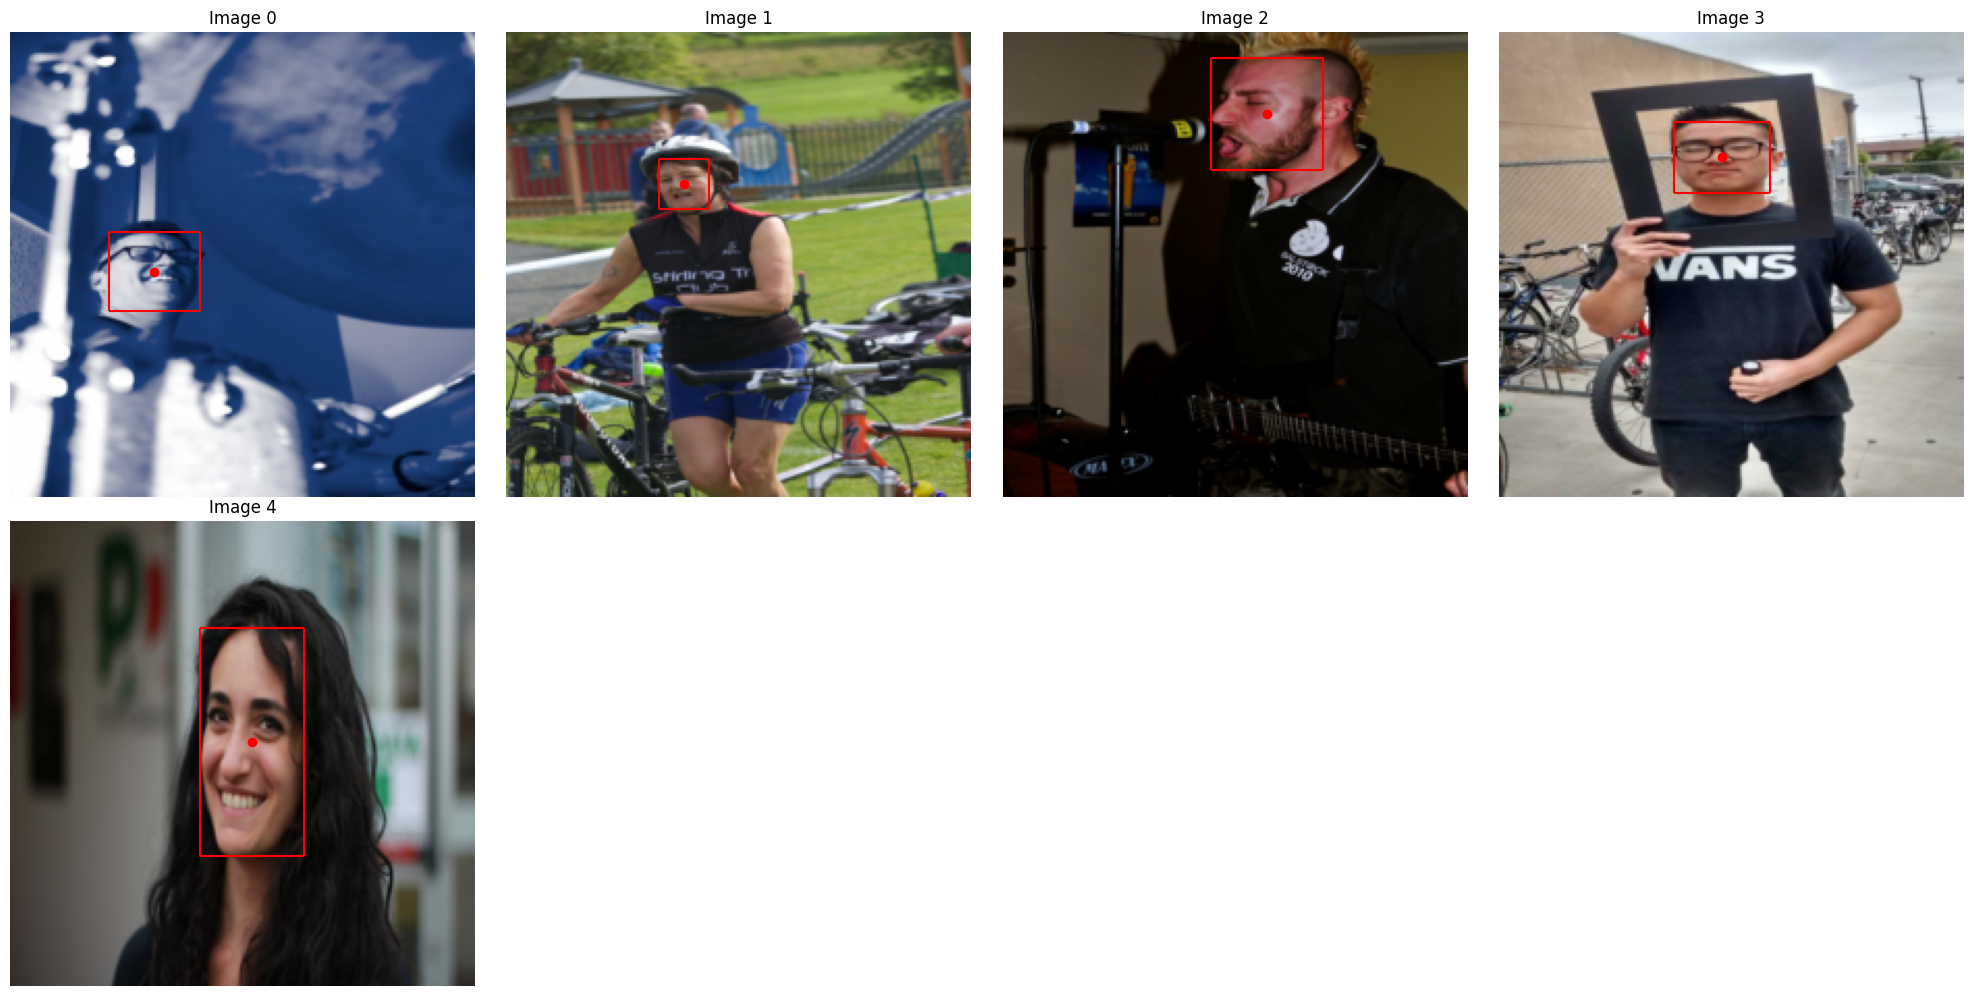

In [152]:
X_dev, y_dev = process_and_pad_data(X_pth_dev, y_pth_dev)
print("Dev images shape:", X.shape)
print("Dev bboxes shape:", y.shape)

plot_image_grid(X_dev, y_dev, epoch=0)

Ok so we look good now lets train and eval:

In [183]:
class simple_conv(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.l0 = nn.Conv2d(3,16,5)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.l1 = nn.Linear(16, 5)


    def forward(self, x):
        # print(x.shape)
        x = self.l0(x)
        # print(x.shape)
        x = nn.functional.relu(x)
        # print('pre gap',x.shape)
        x = self.gap(x)
        x = x.squeeze()
        # print(x.shape)
        logits = self.l1(x)
        # print(x.shape)
        return logits

simp_conv = simple_conv()

In [184]:
criterion = nn.MSELoss()
optimizer = optim.Adam(simp_conv.parameters(), lr=0.0003)

In [185]:
lossi = []
devlossi = []

100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


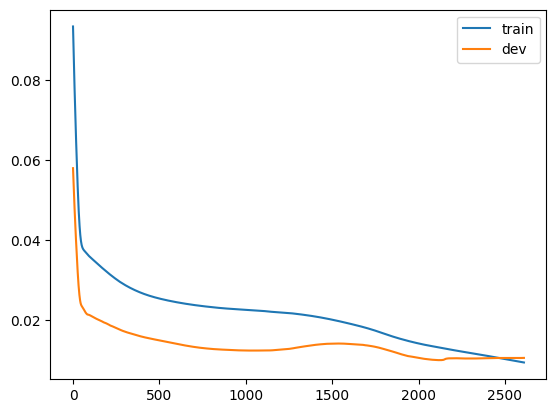

dev loss is: 0.010521898046135902


(None, None)

In [195]:
device = 'mps'
simp_conv = simp_conv.to(device)
X = X.to(device)
y = y.to(device)
X_dev = X_dev.to(device)
y_dev = y_dev.to(device)


for epoch in tqdm(range(1)):
    logits = simp_conv(X)
    loss = criterion(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())

    logits = simp_conv(X_dev)
    loss = criterion(logits, y_dev)
    devlossi.append(loss.item())
    
    # if epoch % 100 == 0:
    #     # plot_image_grid(X.cpu(), logits, epoch=epoch+1)
    #     plt.plot(lossi, label='train')
    #     plt.plot(devlossi, label='dev')
    #     plt.legend()
    #     plt.show()



plt.plot(lossi, label='train')
plt.plot(devlossi, label='dev')
plt.legend()
plt.show(), print(f"dev loss is: {devlossi[-1]}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.002038296..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


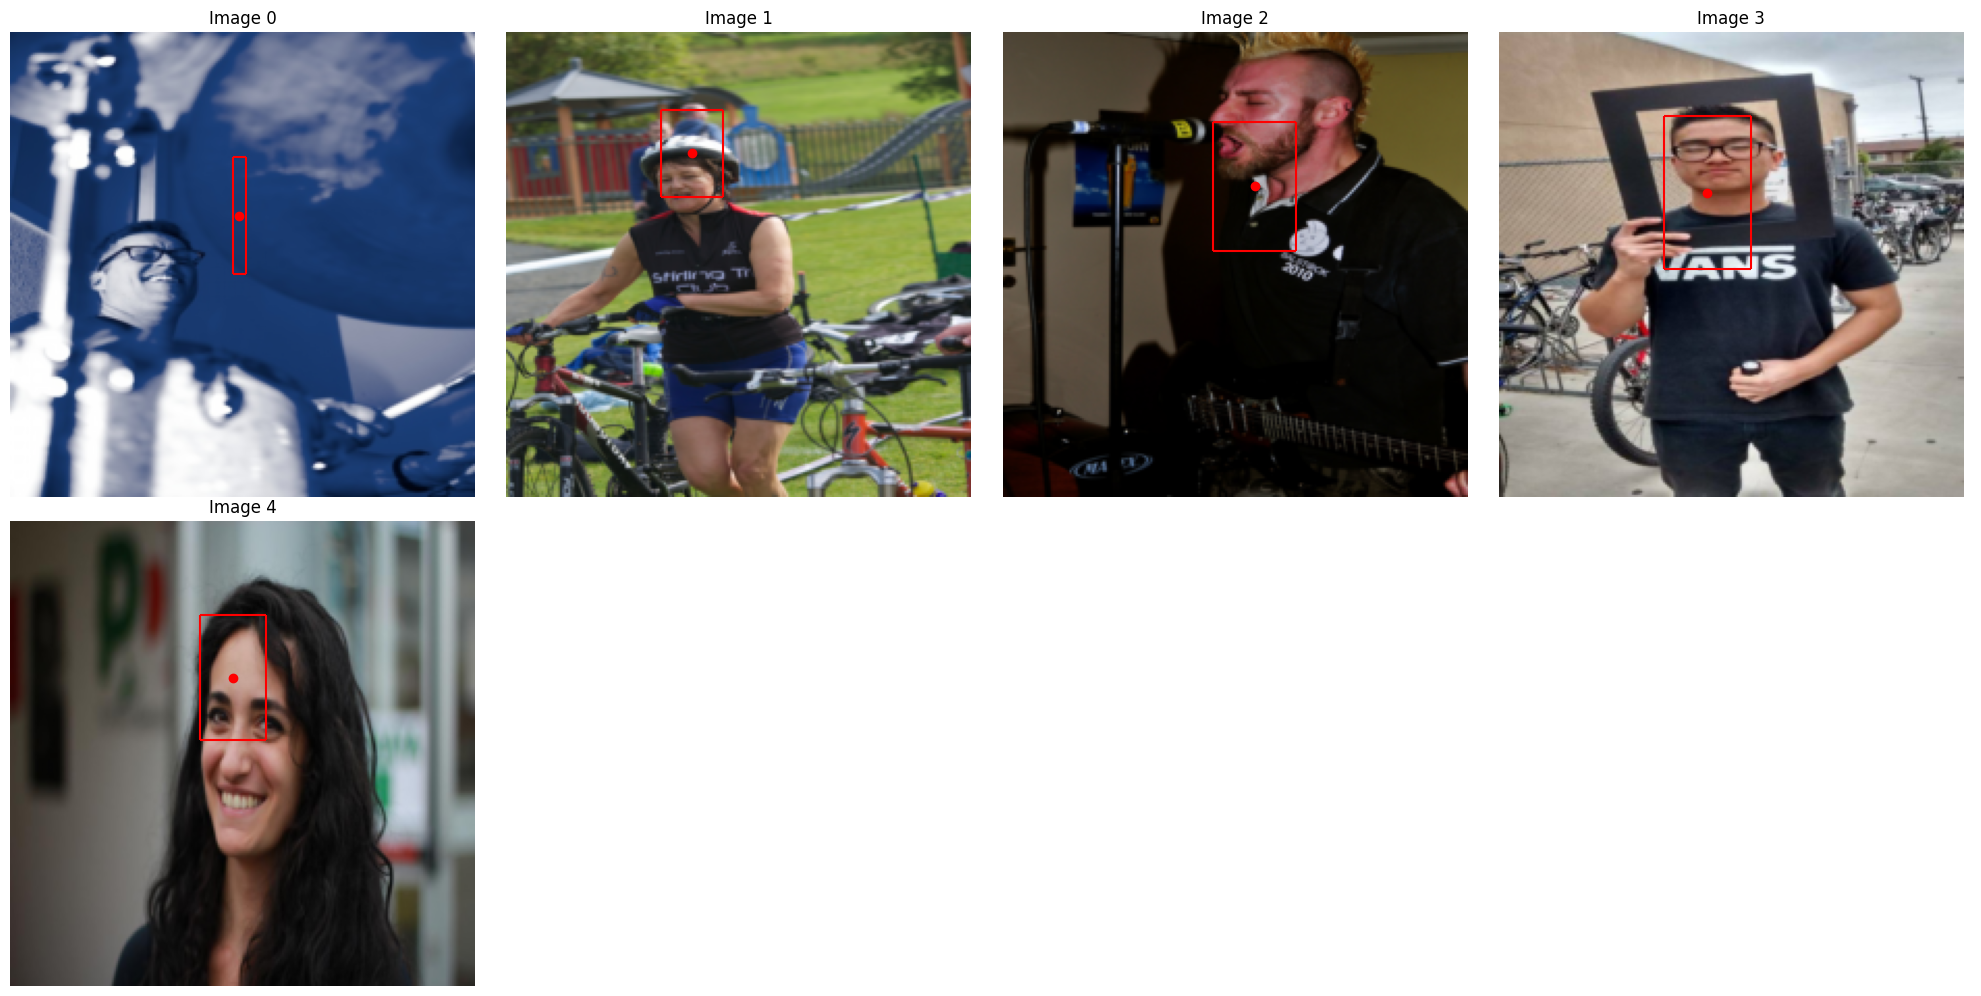

In [196]:
dev_logits = simp_conv(X_dev)
dev_logits = dev_logits.cpu()
X_dev = X_dev.cpu()
plot_image_grid(X_dev, dev_logits, epoch='Dev')

So this blows you can see that it leaned to just put the square in the center for lowest loss